# Speech Recognition
- Author: Ashish Sharma

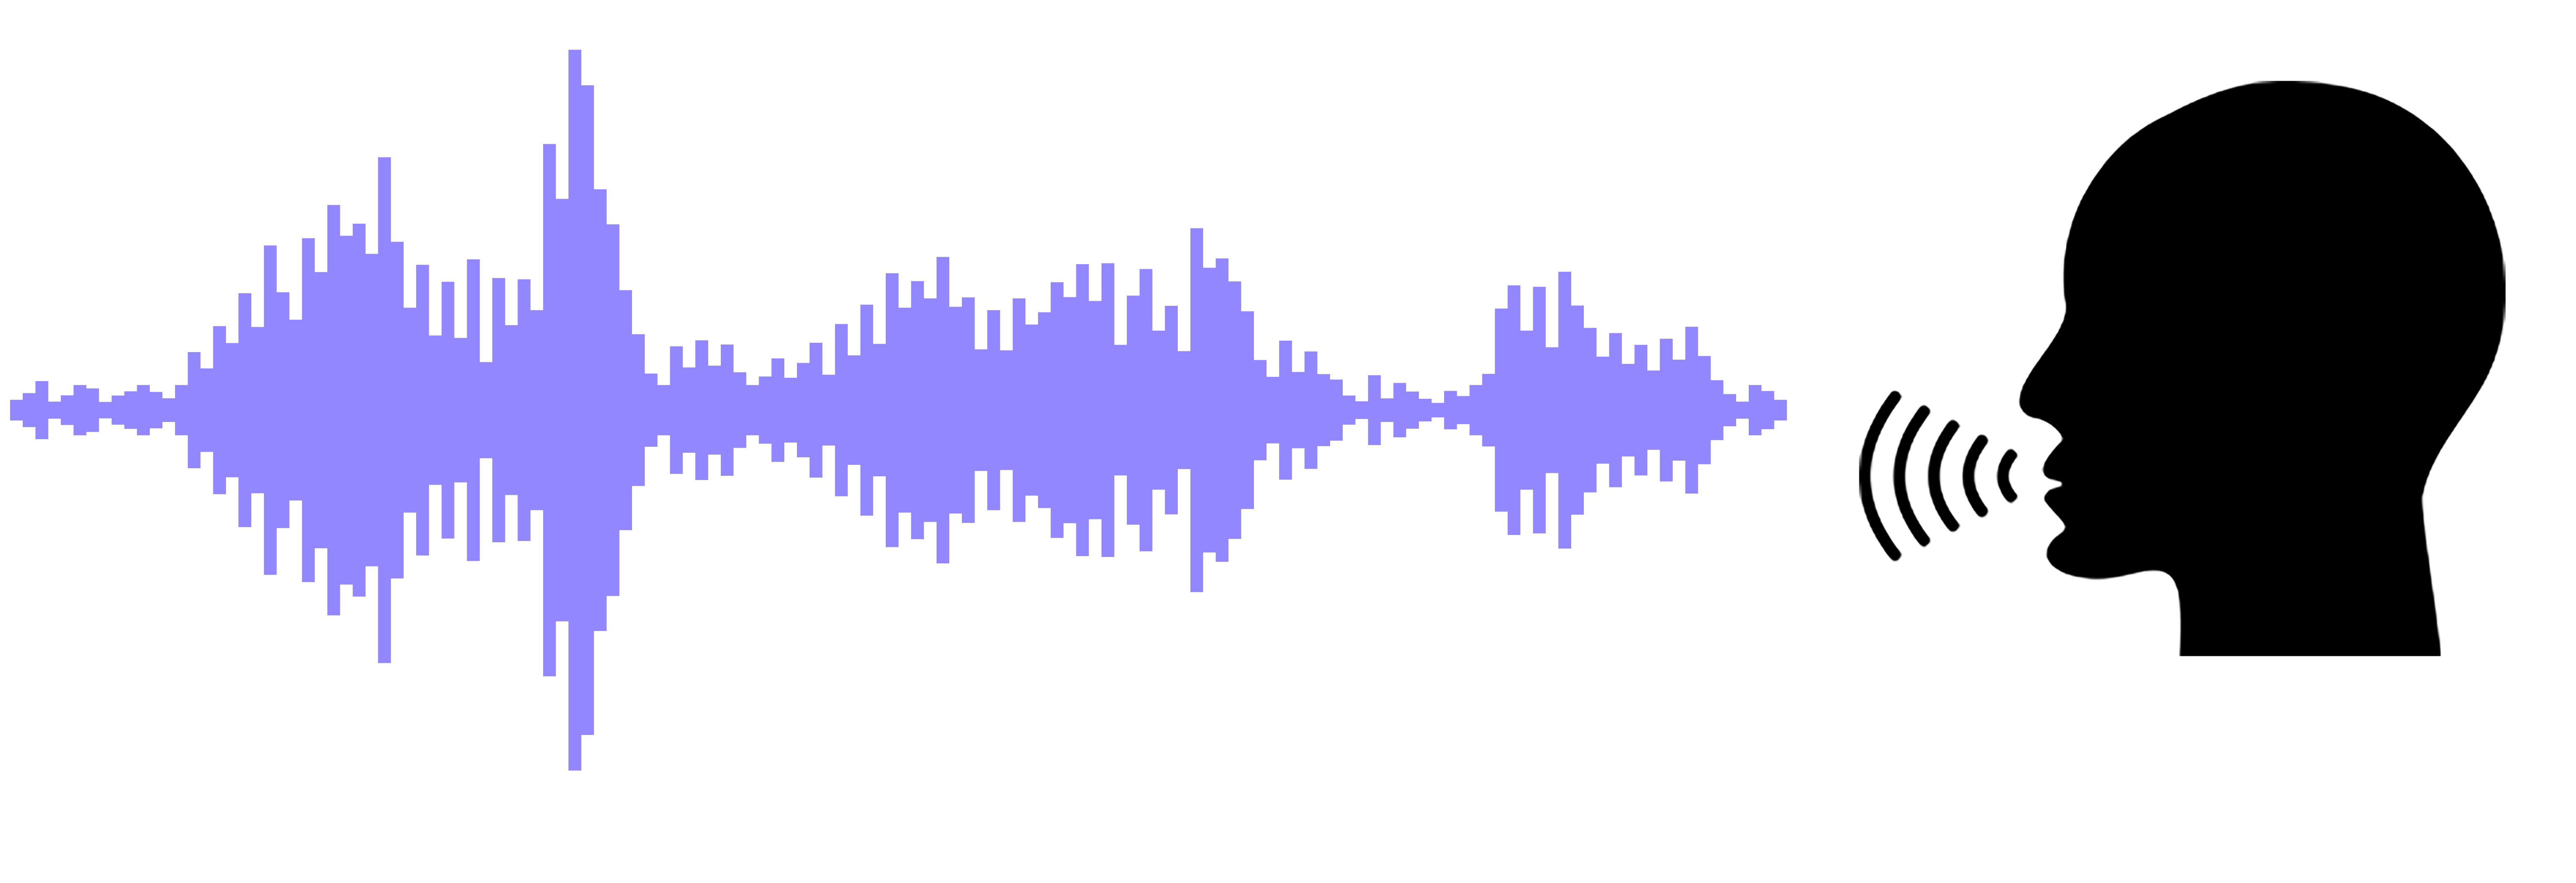


Dataset Used:
- A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
- 2,000 recordings (50 of each digit per speaker)

#### Different Feature Extraction Techniques for an Audio Signal

1.) Time-Domain
- The audio signal is represented by the amplitude as a function of time. The limitation of the time-domain analysis is that it completely ignores the information about the rate of the signal which is addressed by the frequency domain analysis.

2.) Frequency Domain
- The audio signal is represented by amplitude as a function of frequency. It is a plot between frequency and amplitude.The limitation of this frequency domain analysis is that it completely ignores the order or sequence of the signal which is addressed by time-domain analysis.

3.) Spectrogram
- To get the time-dependent frequencies spectrogram us used. It’s a 2D plot between time and frequency where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color.

### Importing all the libraries and the sound files

In [229]:
# Importing all the required libraries
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [230]:
# Defining the path where I have placed the sound files
path = 'C:/Users/nick2/Desktop/MS/record/'

# Using librosa to load the audio file, which decodes it into a 1-D array which is time series - 'samples', and 'sr' which is
# the sampling rate of the audio file
samples, sr = librosa.load(path+'0_theo_38.wav', sr = None)
print('Number of samples: {} and sample rate: {}'.format(len(samples),sr))

Number of samples: 4314 and sample rate: 8000


### Playing an Audio

In [231]:
# Loading an audio file and listening to it in jupyter notebook
samples, sample_rate = librosa.load(path+'0_theo_38.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

### Plotting the sound wave in time-domain

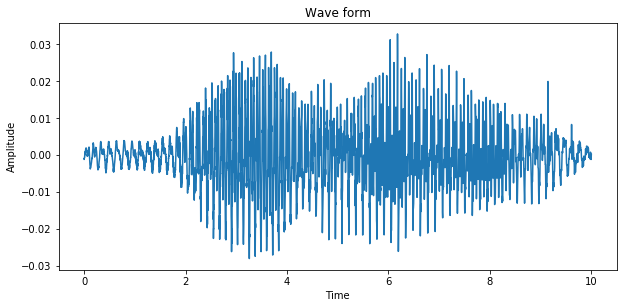

In [232]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
ax.set_title('Wave form')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.plot(np.linspace(0, 10, len(samples)), samples)

### Distribution of each label of sound

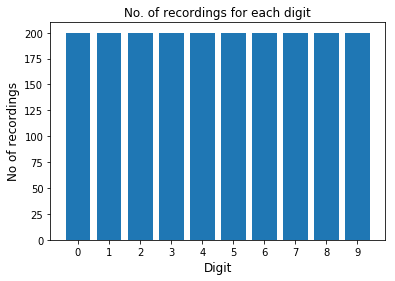

In [233]:
path = 'C:/Users/nick2/Desktop/MS/record/'
labels=os.listdir(path)

#find count of each label and plot bar graph
labels = []
number_of_records = []
for f in os.listdir(path):
    if f.endswith('.wav'):
        label = f.split('_')[0]
        labels.append(label)
        
label_dic={}
for i in labels:
    if i in label_dic:
        label_dic[i]+=1
    else:
        label_dic[i]=1

plt.bar(label_dic.keys(),label_dic.values())
plt.title('No. of recordings for each digit')
plt.xlabel('Digit', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.show()

### Distribution of the duration of the recordings
- I have created separate folder for each label from 0 to 9, where each folder has 200 recordings
- Sample rate is number of samples per second <br>
     Time = number of samples/sample rate


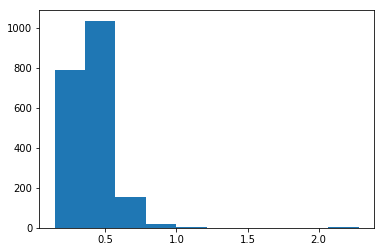

In [234]:
path = 'C:/Users/nick2/Desktop/MS/record1/'

categories=['0','1','2','3','4','5','6','7','8','9']

duration=[]

for label in categories:
    waves = [f for f in os.listdir(path+'/'+label) if f.endswith('.wav')]
    for file in waves:
        samples, sr = librosa.load(path + '/' + label + '/'+file, sr = None)
        duration.append(float(len(samples)/sr)) 
    
plt.hist(np.array(duration))
plt.show()


-  About half the sound recordings are of 0.5 seconds

### Data Preprocessing
- I need to vectorize the sound samples in order to put them in the model.

####  Creating a function to get the MFCCs of an audio signal

In [235]:
def get_mfcc(file_path, max_pad_len=20):
    x, sr = librosa.load(file_path, mono=True, sr=None)
    
    # Jumping every 3rd index of the array
    x = x[::3]
    
    # Getting MFCCs for the audio signal 
    mfcc = librosa.feature.mfcc(x, sr=8000)
    
    # Calculating the padding width to make number of rows equal to number of column in the feature matrix
    pad_width = max_pad_len - mfcc.shape[1]
    
    # Making mfcc a square-matrix
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

####  Creating a function to get the MFCCs of all the audio signals and converting them into an array, also extracting labels out of each audio file and storing it in labels
- MFCC of each audio file is of shape 20x20
- MFCCs of all the audio files after converting into array will be of shape (2000,20,20)
- Similarly converting 2000 labels with 10 classes into an array will result in an array of shape 2000x10

In [236]:
def get_data():
    labels = []
    mfccs = []
    for i in os.listdir('./record'):
        if i.endswith('.wav'):
            # Extracting the MFCC features of each audio file and storing it
            mfccs.append(get_mfcc('./record/' + i))
            # Extracting the label of each audio file and appending it 
            label = i.split('_')[0]
            labels.append(label)
    return np.asarray(mfccs), to_categorical(labels)

### Modeling

- Designing a Multilayer Perceptron using Convolution Neural Network

In [237]:
def cnn_model(input_shape, num_classes):
# Defining a sequential model    
    model = Sequential()

# Feature Learning Layers  -- Convolution - RELU 1st Block, Minimum of three such blocks is what I go with a rule of thumb
    
    # This is the input layer, so input shape has to be given, this layer uses 32 feature maps of size 2x2
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    # Convolution - RELU 2nd Block. This layer uses 64 feature maps of size 3x3
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    # Convolution - RELU 3rd Block, using 128 feature maps, size 5x5
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    
    # I tried using same kernel size with different number of feature maps but this is the combination with which I got the
    # best results in limited amount of time

    # Max Pooling layer with pooling matrix of size 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening the vector to input it into the model
    model.add(Flatten())

# Classification layers    

    # First hidden layer has 128 Neurons and it also represents the dimension of its output space
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Second hidden layer has 64 Neurons and it is the dimension of its output space.
    # Most of the problems are solved using 1 to 2 hidden layers,there are very few situations 
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # This is the final layer in the model, it has num_classes number of neurons which is 10 in our case. Activation function 
    # used here is softmax as here it will classify the input into on of the 10 output classes
    model.add(Dense(num_classes, activation='softmax'))
    
    # Loss function used is categorical_crossentropy as it is a multiclass-classification problem 
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    return model

#### Creating a function that extracts all the labels and MFCC features from the audio dataset, splits the data into training and test set and complies the Neural Network we created above

In [238]:
def get_all():
    # Getting the mfcc feature set and labels from the dataset
    mfccs, labels = get_data()
    dimension_1 = mfccs.shape[1]
    dimension_2 = mfccs.shape[2]
    # Total categories of the labels (0-9)
    classes = 10
    X = mfccs
    X = X.reshape((mfccs.shape[0], dimension_1, dimension_2, 1))
    y = labels

    input_shape = (dimension_1, dimension_1, 1)
    
    # Splitting the data into train and test with 20% of the data as test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Compiling the Model
    model = cnn_model(input_shape, classes)

    return X_train, X_test, y_train, y_test, model

### Model Training

In [239]:
# Calling the get_all function to get the training and test set, and the compiled Neural Network model
X_train, X_test, y_train, y_test, cnn_model = get_all()
#print(cnn_model.summary())

In [240]:
# We are monitoring validation loss and creating a check point, so that only when there is an improvement in the validation
# accuracy, the model is saved. 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,  patience=7) 
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history=cnn_model.fit(X_train, y_train ,epochs=20, callbacks=[es,mc], batch_size=64,verbose=1, validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 18s 14ms/step - loss: 2.2569 - acc: 0.2867 - val_loss: 1.8145 - val_acc: 0.4437

Epoch 00001: val_acc improved from -inf to 0.44375, saving model to model.h5
Epoch 2/20
1280/1280 [==============================] - 10s 8ms/step - loss: 1.4886 - acc: 0.4984 - val_loss: 1.0356 - val_acc: 0.6406

Epoch 00002: val_acc improved from 0.44375 to 0.64062, saving model to model.h5
Epoch 3/20
1280/1280 [==============================] - 9s 7ms/step - loss: 1.0948 - acc: 0.6305 - val_loss: 0.7025 - val_acc: 0.7625

Epoch 00003: val_acc improved from 0.64062 to 0.76250, saving model to model.h5
Epoch 4/20
1280/1280 [==============================] - 10s 7ms/step - loss: 0.8409 - acc: 0.7219 - val_loss: 0.6016 - val_acc: 0.8156

Epoch 00004: val_acc improved from 0.76250 to 0.81563, saving model to model.h5
Epoch 5/20
1280/1280 [==============================] - 10s 8ms/step - loss: 0.7022 - acc: 0

### Plotting the training loss and validation loss with number of epochs

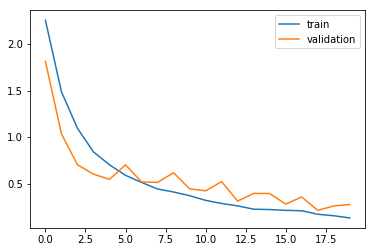

In [241]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='validation') 
plt.legend() 
plt.show() 

### Creating a function to make predictions on test data

In [242]:
def predict(X, y):
    # Loading the saved model
    trained_model = keras.models.load_model('model.h5')
    # Making the predictions
    predictions = trained_model.predict_classes(X)
    
    print(classification_report(y, to_categorical(predictions)))

# Predicting the Test dataset and printing the classification report
predict(X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        41
           1       0.87      0.89      0.88        38
           2       0.89      0.89      0.89        38
           3       0.87      0.95      0.91        42
           4       1.00      0.90      0.95        40
           5       0.98      0.96      0.97        45
           6       0.89      0.87      0.88        38
           7       0.84      0.95      0.89        38
           8       0.89      0.94      0.92        35
           9       0.93      0.89      0.91        45

   micro avg       0.91      0.91      0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400
 samples avg       0.91      0.91      0.91       400



========================================================================================================================

### Predicting User recorded sound
- Create a function to predict user recorded sound
- Take input from user
- Listen to it
- Predict it using our Neural Network

In [354]:
# Function for predicting a user input sound recording
def predict_user_input(x):
    x = x[::3]
    mfcc_comp = librosa.feature.mfcc(x, sr=8000)
    pad_width = 20 - mfcc_comp.shape[1]
    mfcc_comp = np.pad(mfcc_comp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    recording = np.asarray(mfcc_comp)
    recording = recording.reshape((1, 20, 20, 1))
    trained_model = keras.models.load_model('model.h5')
    predictions = trained_model.predict_classes(recording)
    print('Model Prediction: {}'.format(predictions[0]))

In [455]:
# Taking user input for a recording
samplerate = 8000  
duration = 0.6 
filename = 'rec.wav'
print("begin")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

begin
end


In [456]:
# reading the voice commands
os.listdir('C:/Users/nick2/Desktop/MS')
filepath='C:/Users/nick2/Desktop/MS'

x, sr = librosa.load(filepath + '/' + 'rec.wav', mono=True, sr=None)
s = librosa.resample(x, sr, 8000)
ipd.Audio(s,rate=8000)  

In [ ]:
# Predicting user input
predict_user_input(s)